### Notebook to plot BOWTIE sounding data.

James Ruppert  
jruppert@ou.edu  
8/19/24

### Main settings

In [1]:
import sys
sys.path.append('/home/macsyrett/bowtie-soundings/')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
import subprocess, cmocean
import xarray as xr
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import metpy.calc as mpcalc
from time_series_diag import *
from dynamo_read_data import *
from thermo_functions import *

In [72]:
# Soundings

Revelle = '99991'
Diego_Garcia = '61967'
Mirai = '99990'
Gan = '43599'

snd_asc, snd_files, times_asc = read_dynamo_soundings(search_string = Diego_Garcia)
# soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'descen')
hght = snd_asc['hght']

Failed to read  61967_L4_5hPa20111007T2321_v1.0.1.nc
Failed to read  61967_L4_5hPa20111008T0223_v1.0.1.nc
Failed to read  61967_L4_5hPa20111009T0823_v1.0.1.nc
Failed to read  61967_L4_5hPa20111010T1123_v1.0.1.nc
Failed to read  61967_L4_5hPa20111012T1718_v1.0.1.nc
Failed to read  61967_L4_5hPa20111016T0533_v1.0.1.nc
Failed to read  61967_L4_5hPa20111031T1118_v1.0.1.nc
Failed to read  61967_L4_5hPa20111104T0550_v1.0.1.nc
Failed to read  61967_L4_5hPa20111108T1132_v1.0.1.nc
Failed to read  61967_L4_5hPa20111109T0821_v1.0.1.nc
Failed to read  61967_L4_5hPa20111111T0215_v1.0.1.nc
Failed to read  61967_L4_5hPa20111111T0317_v1.0.1.nc
Failed to read  61967_L4_5hPa20111111T0515_v1.0.1.nc
Failed to read  61967_L4_5hPa20111111T0818_v1.0.1.nc
Failed to read  61967_L4_5hPa20111115T2331_v1.0.1.nc
Failed to read  61967_L4_5hPa20111124T2330_v1.0.1.nc
Failed to read  61967_L4_5hPa20111201T2321_v1.0.1.nc
Failed to read  61967_L4_5hPa20111204T0219_v1.0.1.nc
Failed to read  61967_L4_5hPa20111211T1717_v1.

### Compute diagnostics

In [73]:
print(snd_asc['p'])
print(snd_asc['tmpk'])

[[1011.29998779 1010.39564846 1009.26303852 ...           nan
            nan           nan]
 [1009.09997559 1008.19639968 1007.0669298  ...           nan
            nan           nan]
 [1010.40002441 1009.48863636 1008.35227273 ...           nan
            nan           nan]
 ...
 [1010.09997559 1009.19318186 1008.05681826 ...           nan
            nan           nan]
 [1006.79998779 1005.89433354 1004.76297965 ...           nan
            nan           nan]
 [1008.59997559 1007.69716044 1006.5686415  ...           nan
            nan           nan]]
[[301.44998169 300.96303791 300.6026077  ...          nan          nan
           nan]
 [300.04998779 300.3585264  300.74419966 ...          nan          nan
           nan]
 [299.25       299.50907933 299.41817162 ...          nan          nan
           nan]
 ...
 [300.1499939  300.08544943 299.99454173 ...          nan          nan
           nan]
 [300.1499939  300.04935882 299.94524244 ...          nan          nan
           n

In [74]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
    rho = density_moist(tmpk, mr, p) # kg/m3
    dz = hght[1]-hght[0] # m
    var_int = np.nansum(invar*rho, axis=1, where=(p > minpres))*dz
    var_int[ np.where(var_int == 0) ] = np.nan
    return var_int

In [75]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(snd_asc['tmpk']-273.15)

minpres=50e2 # Upper pressure bound for vertical integrals [Pa]

# MSE
mr = mpcalc.mixing_ratio_from_relative_humidity(snd_asc['p']*units.hPa, snd_asc['tmpk']*units.K, snd_asc['rh'])

dse = cp*snd_asc['tmpk'] + g*hght[np.newaxis,:]
lvq= lv*mr
mse = dse + lvq

# Static stability
theta = theta_dry_kelvin_hpa(snd_asc['tmpk'], snd_asc['p'])
def smooth_theta(invar, nz_smooth=10):
    invar_pd = pd.DataFrame(invar)
    invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(invar_pd))
for ido in range(3):
    theta = smooth_theta(theta, nz_smooth=10)
dthdz = np.gradient(theta, hght, axis=1) # K/m
# for ido in range(10):
dthdz = smooth_theta(dthdz, nz_smooth=20)

tmpk_ddz = np.copy(snd_asc['tmpk'])
for ido in range(3):
    tmpk_ddz = smooth_theta(tmpk_ddz, nz_smooth=10)
dtdz = np.gradient(tmpk_ddz, hght, axis=1) # K/m
dtdz = smooth_theta(dtdz, nz_smooth=20)

# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(mr, snd_asc['tmpk'], mr, snd_asc['p'],
                    hght, minpres=0) # mm or kg/m2

/tmp/ipykernel_47342/1335988980.py:23: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
/tmp/ipykernel_47342/1335988980.py:23: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
/tmp/ipykernel_47342/1335988980.py:23: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  invar_pd = invar_pd.rolling(axis=1,window=nz_smooth, center=True, closed='both', min_periods=3).mean()
/tmp/ipykernel_47342/1335988980.py:23: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future versi

---
### Plotting routines

#### Plot functions

In [76]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

# sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})

In [77]:
# def do_smooth(invar, nt_smooth=3, nz_smooth=10):
def do_smooth(invar, nt_smooth=8, nz_smooth=10):
    # Use Pandas to compute rolling average
    invar_pd = pd.DataFrame(invar)
    var_sm1 = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
    # var_trns = var_sm1.transpose()
    # var_sm = var_trns.rolling(window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    # var_sm = var_sm1.transpose()
    # return np.squeeze(np.array(var_sm.transpose()))
    return np.squeeze(np.array(var_sm1))
# def do_smooth(invar, nt_smooth=3, nz_smooth=10):
def do_smooth_2d(invar, nt_smooth=8):
    # Use Pandas to compute rolling average
    invar_pd = pd.DataFrame(invar)
    var_sm = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(var_sm))

In [78]:
def plot_time_height(figdata, smooth=False, top=18, do_log=False):

    fig_x = 9
    fig_y = 3.5
    fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

    ax.set_title(figdata['fig_title'])

    ax.set_ylabel('Height [km]')
    ax.set_ylim(0,top)
    # ax.set_xlim(figdata['xlim'])
    ax.set_xlabel('Date [UTC]')

    ax.grid(True, axis='x', color='0.55', linewidth=0.5, zorder=4)
    ax.grid(True, axis='y', color='0.55', linewidth=0.5, zorder=4)#, which='both')

    # Plot variable
    xdim=figdata['time']
    pltvar = figdata['pltvar']
    if smooth:
        pltvar = do_smooth(pltvar)

    # norm=colors.Normalize(np.min(figdata['clevels']), np.max(figdata['clevels']))
    # im = ax.pcolormesh(np.repeat(xdim[:,np.newaxis],len(hght),axis=1), np.repeat(hght[np.newaxis,:]*1e-3,len(xdim),axis=0), pltvar, cmap=figdata['cmap'], shading='gouraud', norm=norm)#figdata['norm'])
    im = ax.contourf(xdim, hght*1e-3, pltvar.transpose(), figdata['clevels'],
                    extend=figdata['extend'], cmap=figdata['cmap'], zorder=0)#, norm=norm)
    fig.colorbar(im, ax=ax, label=figdata['units'], ticks=ticker.AutoLocator())#, shrink=0.6)

    # Line contours
    im = ax.contour(xdim, hght*1e-3, pltvar.transpose(), figdata['clevels_line'],
                    colors=figdata['clevels_line_color'],linewidths=0.6, zorder=1)

    # 0ºC level
    hght0c = snd_asc['hght_0c']*1e-3
    if smooth:
        invar_pd = pd.DataFrame(hght0c)
        nt_smooth=3
        invar_sm = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
        hght0c=np.squeeze(np.array(invar_sm))
    # ax.plot(figdata['time'], hght0c, color='#d62728', zorder=3, linewidth=2)

    # Time labels
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    plt.show()
    plt.close()
    return

In [79]:
def plot_time_height_subpanel(figdata, smooth=False, cwv=None, do_log=False, top=18):

    fig_x = 9
    # fig_y = 3.5
    # fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column
    fig_y = 6
    fig, axs = plt.subplots(2, 1, figsize=(fig_x,fig_y), height_ratios=[.65,.35], layout='constrained',squeeze=True)

    axs[0].set_title(figdata['fig_title'])

    axs[0].set_ylabel('Height [km]')
    axs[0].set_ylim(0,top)
    axs[0].set_xlim(figdata['xlim'])
    # axs[0].set_xlabel('Date')

    axs[0].grid(True, axis='x', color='0.55', linewidth=0.5, zorder=4)
    axs[0].grid(True, axis='y', color='0.55', linewidth=0.5, zorder=4)#, which='both')

    # Plot variable
    xdim=figdata['time']
    pltvar = figdata['pltvar']
    if smooth:
        pltvar = do_smooth(pltvar)

    # norm=colors.Normalize(np.min(figdata['clevels']), np.max(figdata['clevels']))
    # im = ax.pcolormesh(np.repeat(xdim[:,np.newaxis],len(hght),axis=1), np.repeat(hght[np.newaxis,:]*1e-3,len(xdim),axis=0), pltvar, cmap=figdata['cmap'], shading='gouraud', norm=norm)#figdata['norm'])
    im = axs[0].contourf(xdim, hght*1e-3, pltvar.transpose(), figdata['clevels'],
                    extend=figdata['extend'], cmap=figdata['cmap'], zorder=0)#, norm=figdata['norm'])
    fig.colorbar(im, ax=axs[0], label=figdata['units'], ticks=ticker.AutoLocator())#, shrink=0.6)

    # Line contours
    im = axs[0].contour(xdim, hght*1e-3, pltvar.transpose(), figdata['clevels_line'],
                    colors=figdata['clevels_line_color'],linewidths=0.6, zorder=1)

    # 0ºC level
    hght0c = snd_asc['hght_0c']*1e-3
    if smooth:
        invar_pd = pd.DataFrame(hght0c)
        nt_smooth=3
        invar_sm = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
        hght0c=np.squeeze(np.array(invar_sm))
    # ax.plot(figdata['time'], hght0c, color='#d62728', zorder=3, linewidth=2)

    # Time labels
    axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
    axs[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))
    # axs[0].get_xaxis().set_ticks([' ', ' ',' ',' ',' ',' ',' ',' '])

    # Hide labels
    axs[0].xaxis.set_ticklabels([])

    ##################################################

    # CWV SUBPANEL
    axs[1].set_ylabel('IWV [mm]')
    axs[1].set_ylim(48,66)

    # Time labels
    axs[1].set_xlim(figdata['xlim'])
    axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

    cwv_plt = np.copy(cwv)
    if smooth:
        cwv_plt = do_smooth_2d(cwv_plt)
    axs[1].plot(xdim, cwv_plt, '-k')
    axs[1].set_xlabel('Date')

    # axs[1].axhline(y=48, color='red', linewidth=0.8, zorder=0)

    plt.show()
    plt.close()
    return

#### Time-height series

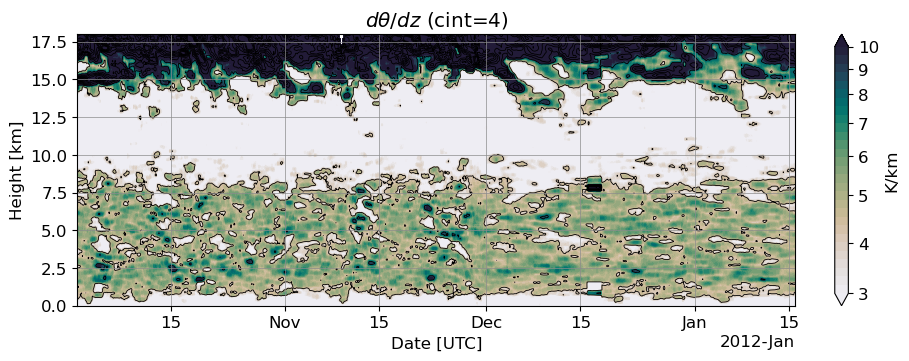

In [80]:
xlim=(times_asc[0],times_asc[-1])
# xlim=(times_asc[-48*2],times_asc[-1])
# xlim=[np.datetime64('2024-08-23T00:00'), np.datetime64('2024-08-27T00:00')]

# d(th)/dz

cint_lines = 4
contours = np.arange(cint_lines,cint_lines*10,cint_lines)

# dthdz_asc = np.copy(dthdz)
# dthdz_asc -= (np.nanmean(dthdz_asc, axis=0))[np.newaxis,:]

figdata = {
    'pltvar': dthdz*1e3,
    'time': times_asc,
    'fig_title': r'$d\theta/dz$ (cint='+str(cint_lines)+')',
    'units': 'K/km',
    'cmap': cmocean.cm.rain,
    'clevels': np.logspace(0.5,1.,num=30),
    'clevels_line': contours,
    'clevels_line_color': 'black',
    'extend': 'both',
    'xlim': xlim,
           }

plot_time_height(figdata, smooth=True, do_log=True)

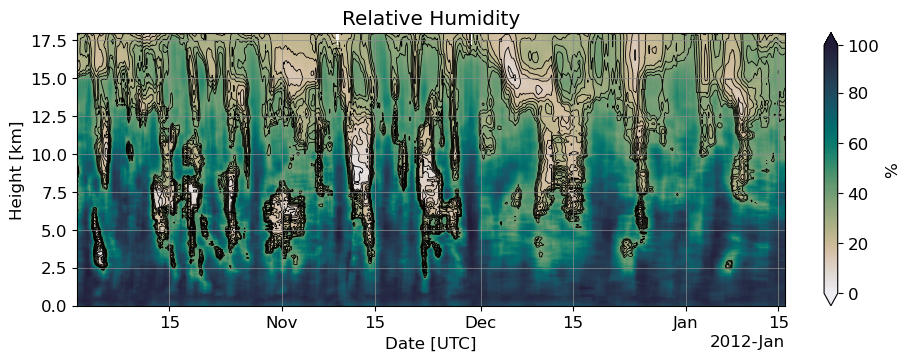

In [81]:
xlim=(times_asc[0],times_asc[-1])
# xlim=(times_asc[-48*2],times_asc[-1])
# xlim=[np.datetime64('2024-08-23T00:00'), np.datetime64('2024-08-27T00:00')]

# d(th)/dz

cint_lines = 4
contours = np.arange(cint_lines,cint_lines*10,cint_lines)

# dthdz_asc = np.copy(dthdz)
# dthdz_asc -= (np.nanmean(dthdz_asc, axis=0))[np.newaxis,:]

figdata = {
    'pltvar': snd_asc['rh'],
    'time': times_asc,
    'fig_title': "Relative Humidity",
    'units': '%',
    'cmap': cmocean.cm.rain,
    'clevels': np.arange(0,100,1),
    'clevels_line': contours,
    'clevels_line_color': 'black',
    'extend': 'both',
    'xlim': xlim,
           }

plot_time_height(figdata, smooth=True, do_log=True)

In [82]:
print(theta)
print(hght)
print(dthdz)

print(snd_asc['tmpk'])
print(snd_asc['rh'])

[[299.73086895 299.71732539 299.70407301 ...          nan          nan
           nan]
 [300.38561693 300.40150993 300.41685854 ...          nan          nan
           nan]
 [298.68534105 298.6900474  298.69472222 ...          nan          nan
           nan]
 ...
 [299.34296219 299.34767738 299.3525616  ...          nan          nan
           nan]
 [299.66143388 299.66608225 299.67091703 ...          nan          nan
           nan]
 [300.68455584 300.67653965 300.66868148 ...          nan          nan
           nan]]
[    0    10    20 ... 30970 30980 30990]
[[-0.00203287 -0.00206074 -0.00204452 ...         nan         nan
          nan]
 [ 0.00222893  0.00227132  0.00227555 ...         nan         nan
          nan]
 [ 0.00084854  0.00090144  0.00094607 ...         nan         nan
          nan]
 ...
 [ 0.000955    0.00102617  0.00108905 ...         nan         nan
          nan]
 [ 0.00088426  0.00093585  0.00097846 ...         nan         nan
          nan]
 [-0.00128089 -0.001

#### CFADS

In [83]:
#def compute_cfad(invar, bins):
#    nz = invar.shape[1]
#    nbin = len(bins)
#    var_freq=np.zeros((nbin-1,nz))
#    print(range(nz))
#    for iz in range(nz):
#        count, placeholder = np.histogram(invar[:,iz], bins=bins)
#        #var_freq[:,iz] = 100 * count / np.sum(count)
#        var_freq[:,iz] = count
#    return var_freq

In [84]:
def compute_cfad(invar, bins):
    nz = invar.shape[1]
    nbin = len(bins)
    hist_density=np.zeros((nbin-1,nz))
    for iz in range(nz):
        count, bin_edges = np.histogram(invar[:,iz], bins=bins, density=True)
        hist_density[:,iz] = count
    return hist_density, bin_edges

In [85]:
def contour_cfad(fig, ax, cfad_var, x, y, meanvar=None, meanrh=None, zeroc=None, plot_legend=False, plot_cbar=False, ianom=False):
    if ianom:
        # norm=colors.Normalize(vmin=-5, vmax=5)
        norm=colors.Normalize(vmin=-.15, vmax=.15)
        cmap='RdBu_r'
    else:
        # norm=colors.Normalize(vmin=0, vmax=15)
        norm=colors.Normalize(vmin=0, vmax=0.25)
        cmap=cmocean.cm.rain
    ax.grid(True, axis='x', color='0.55', linewidth=0.5)
    ax.grid(True, axis='y', color='0.55', linewidth=0.5)#, which='both')
    im = ax.pcolormesh(x, y, cfad_var[:,:-1].transpose(), cmap=cmap, norm=norm)
    # fig.colorbar(im, ax=ax, label='Frequency [%]')#, shrink=0.6)
    if plot_cbar:
        fig.colorbar(im, ax=ax, label='Density', shrink=0.75)
    # Plot mean
    if meanvar is not None:
        ax.plot(meanvar, y, '-', color='#d62728', linewidth=1.9, label=r'Mean d$\theta$/dz')
    # Plot 0ºC
    if zeroc is not None:
        ax.axhline(y=zeroc*1e-3, color='black', linestyle='--', linewidth=1, label='0$^\circ$C')
    if meanrh is not None:
        # This is just to get it into the legend
        ax.axhline(y=zeroc*0, color='green', linewidth=2, label='Mean RH')
    if plot_legend:
        plt.legend(loc='upper left', prop={'size': 10})
    # Plot mean RH
    if meanrh is not None:
        twiny = ax.twiny()
        twiny.plot(meanrh, y, '-', color='green', linewidth=1.9)
        if ianom:
            twiny.set_xlim((-30,30))
        else:
            twiny.set_xlim((25,100))
    return None

In [86]:
def plot_mean_cfad(figdata, plot_legend, plot_cbar, ianom=False):

    fig_x = 5
    fig_y = 4.5
    fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

    ax.set_title(figdata['fig_title'])
    # fig.suptitle(figdata['fig_title'])

    ax.set_ylabel('Height [km]')
    ymax=16
    ax.set_xlim(figdata['bins'].min(),figdata['bins'].max())
    ax.set_ylim(0,ymax)
    ax.set_xlabel(figdata['xtitle'])

    # Plot CFAD
    contour_cfad(fig, ax, figdata['pltvar'], figdata['bins'], hght*1e-3,
                 meanvar=figdata['meanvar'], meanrh=figdata['mean_rh'], zeroc=figdata['zeroc'], plot_legend=plot_legend, plot_cbar=plot_cbar)

    plt.show()
    plt.close()
    return None

In [87]:
def plot_cfad_multi(figdata, fig, ax, plot_legend=False, plot_cbar=False, ianom=False):

    ax.set_title(figdata['fig_title'])

    ax.set_xlim(figdata['bins'].min(),figdata['bins'].max())
    ax.set_ylim(0,16)

    contour_cfad(fig, ax, figdata['pltvar'], figdata['bins'], hght*1e-3,
                 meanvar=figdata['meanvar'], meanrh=figdata['mean_rh'], zeroc=figdata['zeroc'], plot_legend=plot_legend, plot_cbar=plot_cbar, ianom=ianom)

    return None

In [88]:
#def plot_cfad(figdata):
#
#    fig_x = 5
#    fig_y = 4.5
#    fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column
#
#    ax.set_title(figdata['fig_title'])
#    # fig.suptitle(figdata['fig_title'])

#    ax.set_ylabel('Height [km]')
#    ymax=10#20
#    ax.set_xlim(figdata['bins'].min(),figdata['bins'].max())
#    ax.set_ylim(0,ymax)
#    ax.set_xlabel(figdata['xtitle'])
#
#    ax.grid(True, axis='x', color='0.55', linewidth=0.5)
#    ax.grid(True, axis='y', color='0.55', linewidth=0.5)#, which='both')
#
    # Plot CFAD
#    pltvar=figdata['pltvar'][:,:-1]
#    norm=colors.Normalize(vmin=0, vmax=15)
    # norm=colors.LogNorm()#vmin=1, vmax=10)
#    cmap=cmocean.cm.rain
#    im = ax.pcolormesh(figdata['bins'], hght*1e-3, pltvar.transpose(), cmap=cmap, norm=norm)
#    fig.colorbar(im, ax=ax, label='Frequency [%]')#, shrink=0.6)

    # Plot mean
#    ax.plot(figdata['meanvar'], hght*1e-3, '-', color='#d62728', linewidth=1.9, label=r'Mean d$\theta$/dz')

    # Plot 0ºC
#    ax.axhline(y=figdata['zeroc']*1e-3, color='black', linestyle='--', linewidth=1, label='0$^\circ$C')
#    ax.axhline(y=figdata['zeroc']*0, color='green', linewidth=2, label='Mean RH')

#    plt.legend()

    # Plot mean RH
#    if 'mean_rh' in figdata.keys():
#        twiny = ax.twiny()
#        twiny.plot(figdata['mean_rh'], hght*1e-3, '-', color='green', linewidth=1.9)
#        twiny.set_xlim((25,100))

#    plt.show()
#    plt.close()
#    return

/home/macsyrett/.conda/envs/plotting/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


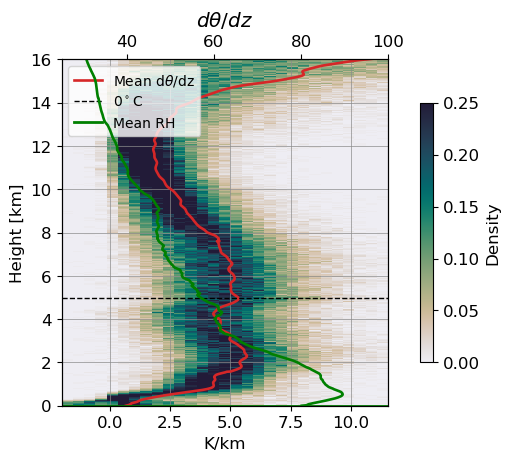

In [89]:
# Bin settings
# nbin=40
# fmin=-2
# fmax=10#15
# step=(fmax-fmin)/nbin
# bins=np.arange(fmin,fmax,step)+step
nbin=30
fmin=-2
fmax=12
step=(fmax-fmin)/nbin
bins=np.arange(fmin,fmax,step)

cfad_invar = dthdz*1e3 # K/km

# var_cfad = compute_cfad(cfad_invar, bins)
cfad_density, bin_edges = compute_cfad(cfad_invar, bins)
var_mean = np.nanmean(cfad_invar, axis=0)


mean_rh = np.nanmean(snd_asc['rh'], axis=0)

figdata = {
    'pltvar': cfad_density,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_mean_cfad(figdata, plot_cbar=True, plot_legend=True)

In [90]:
# # Apply STD thresholds to smoothed CWV to isolate dry/wet periods

# cwv_std = (cwv - np.nanmean(cwv)) / np.nanstd(cwv, axis=0)
# cwv_std = do_smooth_2d(cwv_std)
# std_thresh = .5
# it_dry = np.where(cwv_std < -1*std_thresh)[0]
# it_moist = np.where(cwv_std > std_thresh)[0]
# it_mid = np.where((cwv_std < std_thresh) & (cwv_std > -1*std_thresh))[0]
# print('Percent of full record:')
# print(it_dry.size/cwv.size*1e2)
# print(it_moist.size/cwv.size*1e2)
# print(it_mid.size/cwv.size*1e2)

In [91]:
# Percentile approach for partitioning data into dry/wet periods via CWV

percentiles = [33,66]

cwv_perc = np.nanpercentile(cwv, percentiles)

it_dry = np.where(cwv < cwv_perc[0])[0]
it_moist = np.where(cwv > cwv_perc[1])[0]
it_mid = np.where((cwv > cwv_perc[0]) & (cwv < cwv_perc[1]))[0]
print('Percent of full record:')
print(np.round(it_dry.size/cwv.size*1e2))
print(np.round(it_moist.size/cwv.size*1e2))
print(np.round(it_mid.size/cwv.size*1e2))

Percent of full record:
33.0
34.0
33.0


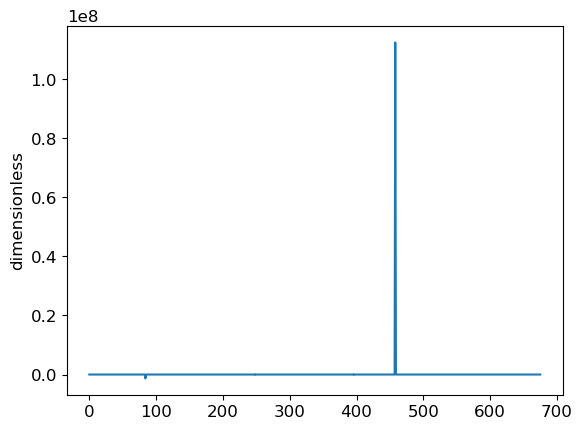

In [92]:
plt.plot(cwv)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


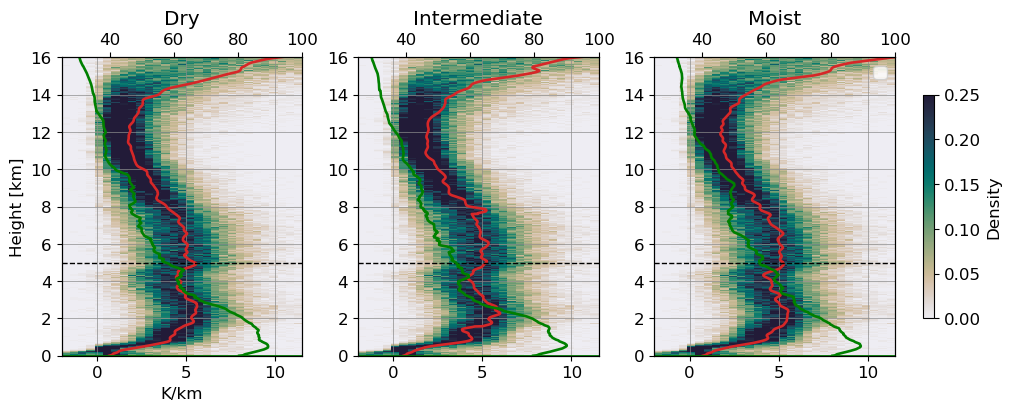

In [93]:


# Dependence on moisture

# Bin settings
nbin=30
fmin=-2
fmax=12
step=(fmax-fmin)/nbin
bins=np.arange(fmin,fmax,step)

# var_cfad = compute_cfad(cfad_invar[it_dry], bins)
cfad_density, bin_edges = compute_cfad(cfad_invar, bins)
var_mean = np.nanmean(cfad_invar[it_dry], axis=0)
mean_rh = np.nanmean(snd_asc['rh'][it_dry], axis=0)

fig_x = 10
fig_y = 4.
fig, axs = plt.subplots(1,3, figsize=(fig_x,fig_y), layout="constrained",) # row, column

figdata = {
    'pltvar': cfad_density,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Dry',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[0])

axs[0].set_ylabel('Height [km]')
axs[0].set_xlabel(figdata['xtitle'])

################################################

var_cfad = compute_cfad(cfad_invar[it_mid], bins)
var_mean = np.nanmean(cfad_invar[it_mid], axis=0)

mean_rh = np.nanmean(snd_asc['rh'][it_mid], axis=0)

figdata = {
    'pltvar': cfad_density,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Intermediate',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[1])

################################################

var_cfad = compute_cfad(cfad_invar[it_moist], bins)
var_mean = np.nanmean(cfad_invar[it_moist], axis=0)

mean_rh = np.nanmean(snd_asc['rh'][it_moist], axis=0)

figdata = {
    'pltvar': cfad_density,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Moist',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[2], plot_cbar=True)

plt.legend()

plt.show()
plt.close()



/home/macsyrett/.conda/envs/plotting/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


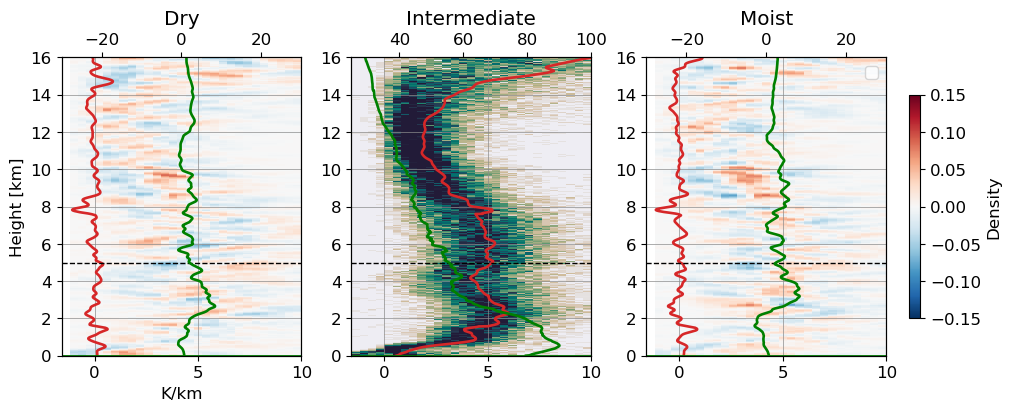

In [94]:
def cfad_smooth(invar, nx_smooth=3, nz_smooth=15):
    invar_pd = pd.DataFrame(invar)
    var_sm1 = invar_pd.rolling(window=nx_smooth, center=True, closed='both', min_periods=3).mean()
    var_trns = var_sm1.transpose()
    var_sm = var_trns.rolling(window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    # var_sm = var_sm2.transpose()
    return np.squeeze(np.array(var_sm.transpose()))
def prof_smooth(invar, nx_smooth=15):
    invar_pd = pd.DataFrame(invar)
    var_sm1 = invar_pd.rolling(window=nx_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(var_sm1))

# Dependence on moisture

# Bin settings
nbin=30
fmin=-2
fmax=10#15
step=(fmax-fmin)/nbin
bins=np.arange(fmin,fmax,step)+step

fig_x = 10
fig_y = 4.
fig, axs = plt.subplots(1,3, figsize=(fig_x,fig_y), layout="constrained",) # row, column

# var_cfad_int = compute_cfad(cfad_invar[it_mid], bins)
cfad_density_int, bin_edges = compute_cfad(cfad_invar[it_mid], bins)
var_mean_int = np.nanmean(cfad_invar[it_mid], axis=0)
mean_rh_int = np.nanmean(snd_asc['rh'][it_mid], axis=0)

# var_cfad = compute_cfad(cfad_invar[it_dry], bins) - var_cfad_int
cfad_density, bin_edges = compute_cfad(cfad_invar[it_dry], bins)
cfad_density -= cfad_density_int
var_mean = np.nanmean(cfad_invar[it_dry], axis=0) - var_mean_int
mean_rh = np.nanmean(snd_asc['rh'][it_dry], axis=0) - mean_rh_int

figdata = {
    'pltvar': cfad_smooth(cfad_density),
    # 'meanvar': var_mean,
    'meanvar': prof_smooth(var_mean),
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    # 'mean_rh':  mean_rh,
    'mean_rh':  prof_smooth(mean_rh),
    'fig_title': 'Dry',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[0], ianom=True)

axs[0].set_ylabel('Height [km]')
axs[0].set_xlabel(figdata['xtitle'])

################################################

mean_rh = np.nanmean(snd_asc['rh'][it_mid], axis=0)

figdata = {
    'pltvar': cfad_density_int,
    'meanvar': var_mean_int,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Intermediate',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[1])

################################################

# var_cfad = compute_cfad(cfad_invar[it_moist], bins) - var_cfad_int
cfad_density, bin_edges = compute_cfad(cfad_invar[it_moist], bins)
cfad_density -= cfad_density_int
var_mean = np.nanmean(cfad_invar[it_moist], axis=0) - var_mean_int
mean_rh = np.nanmean(snd_asc['rh'][it_moist], axis=0) - mean_rh_int

figdata = {
    'pltvar': cfad_smooth(cfad_density),
    # 'meanvar': var_mean,
    'meanvar': prof_smooth(var_mean),
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    # 'mean_rh':  mean_rh,
    'mean_rh':  prof_smooth(mean_rh),
    'fig_title': 'Moist',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[2], plot_cbar=True, ianom=True)

plt.legend()

plt.show()
plt.close()
